<a href="https://colab.research.google.com/github/awanshrestha/fake-news-classification/blob/main/fake_news_classification_svm_awan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string
import os


from bs4 import BeautifulSoup
from textblob import TextBlob

In [7]:
# Import true and fake data

# **Importing data**

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
true = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/True.csv', index_col=False)
fake = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Fake.csv', index_col=False)

In [10]:
# Some info about dataframes:

In [11]:
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [12]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [13]:
true.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [14]:
fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


In [15]:
# As we can see, totally we have something about 50k news divided by 
# fake and not fake news
# Let's check some null values in dataframes:

In [16]:
true.isna().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [17]:
fake.isna().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [18]:
# Okay, now we can concatenate our data's , but before we'll do it, we need 
# to mark them by 1 and 0 (true / fake)

In [19]:
true['target'] = 0

In [20]:
true.head()

,title,text,subject,date,target
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0


In [21]:
fake['target'] = 1

In [22]:
fake.head()

,title,text,subject,date,target
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1


In [23]:
# let's concatenate our data

In [24]:
df = [true, fake]

# Ignore index
data = pd.concat(df, ignore_index=True)

In [25]:
# words count
def words_count(df):
    length = len(str(df).split())
    return length

# characters count

def char_count(df):
    string = df.split()
    x = ''.join(string)
    return len(x)

# hashtags count

def hashtag_count(df):
    hashtag = len([t for t in df.split() if t.startswith('#')])
    return hashtag

# email count

def email_count(df):
    email = len([t for t in df.split() if t.startswith('@')])
    return email

# digits count

def digits_count(df):
    digits = re.findall(r'[0-9]+', df)
    return digits


In [26]:
def get_features(df):
    df['words_count'] = df['text'].apply(lambda x: words_count(x))
    df['char_count'] = df['text'].apply(lambda x: char_count(x))
    df['hashtags_count'] = df['text'].apply(lambda x: hashtag_count(x))
    df['email_counts'] = df['text'].apply(lambda x: email_count(x))
    df['digits_count'] = df['text'].apply(lambda x: digits_count(x))
    
    return df

In [27]:
data = get_features(data)

In [28]:
data.head()

,title,text,subject,date,target,words_count,char_count,hashtags_count,email_counts,digits_count
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0,749,3907,0,0,"[2018, 7, 10, 11, 1, 5, 10, 20, 1, 5, 30, 2018..."
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0,624,3453,0,0,"[1, 21, 1, 8, 1, 1, 2017, 1, 2018]"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0,457,2324,0,0,"[2016, 2018]"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0,376,2085,0,0,"[2016, 30, 2016]"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0,852,4341,0,0,"[2, 2015, 11, 5, 46, 0, 86, 1, 175, 90, 62, 3,..."


# EDA

In [29]:
plt.style.use('ggplot')

plt.rcParams['figure.figsize'] = [8,4]
plt.rcParams['figure.dpi'] = 120

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Counts')

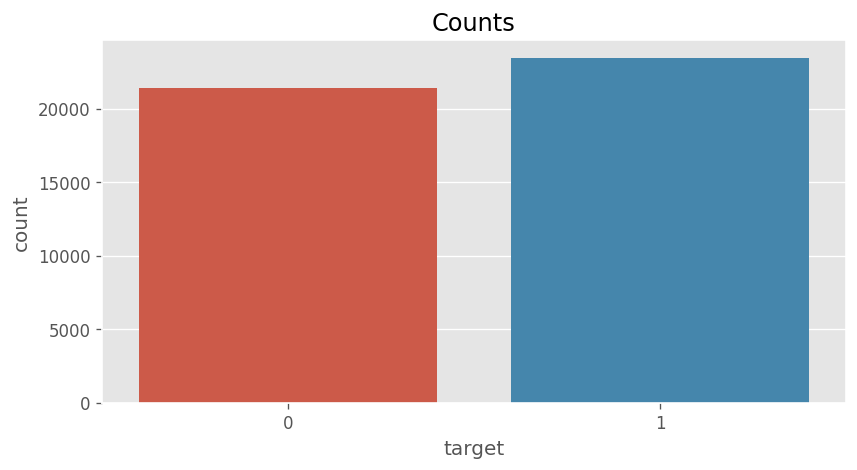

In [30]:
# Value count on sns.countplot

sns.countplot('target', data=data)
plt.title('Counts')

Text(0.5, 1.0, 'Correlation between number of words and target')

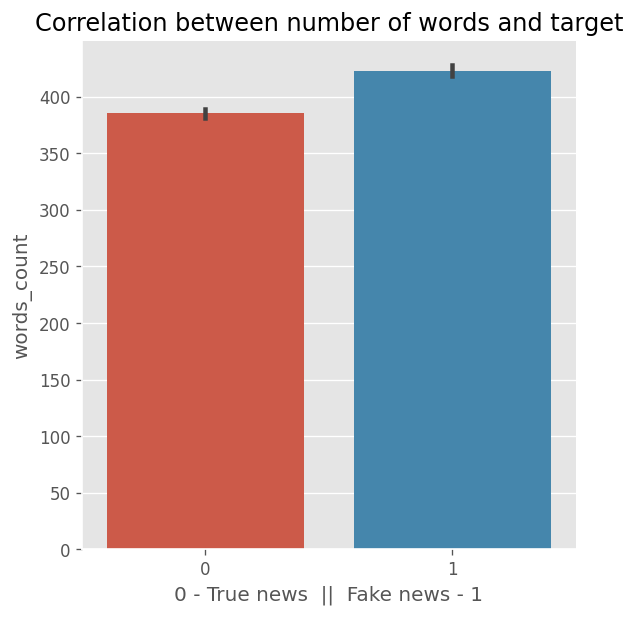

In [31]:
sns.catplot(x='target', y='words_count', kind='bar', data=data)
plt.xlabel('0 - True news  ||  Fake news - 1')
plt.title('Correlation between number of words and target')

In [32]:
# As we can see, fake news have more words count

Text(0.5, 1.0, 'Correlation between hashtags and target')

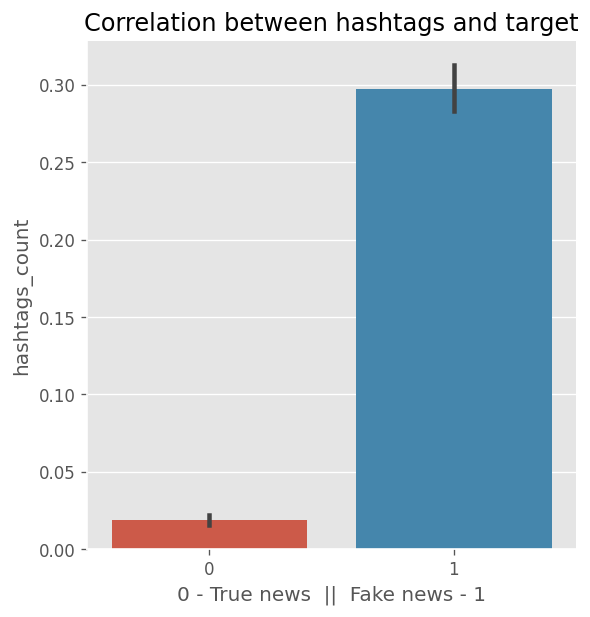

In [33]:
sns.catplot(x='target', y='hashtags_count', kind='bar', data=data)
plt.xlabel('0 - True news  ||  Fake news - 1')
plt.title('Correlation between hashtags and target')

Text(0.5, 1.0, 'Correlation between email and target')

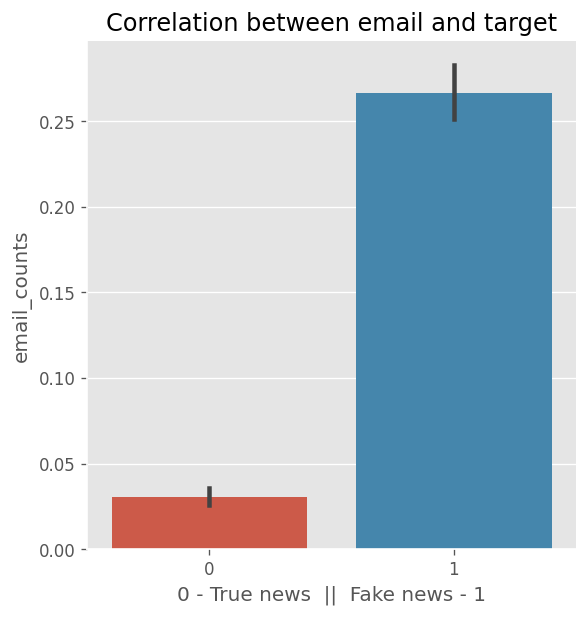

In [34]:
sns.catplot(x='target', y='email_counts', kind='bar', data=data)
plt.xlabel('0 - True news  ||  Fake news - 1')
plt.title('Correlation between email and target')

Text(0.5, 37.000000000000014, '0 - True news  ||  Fake news - 1')

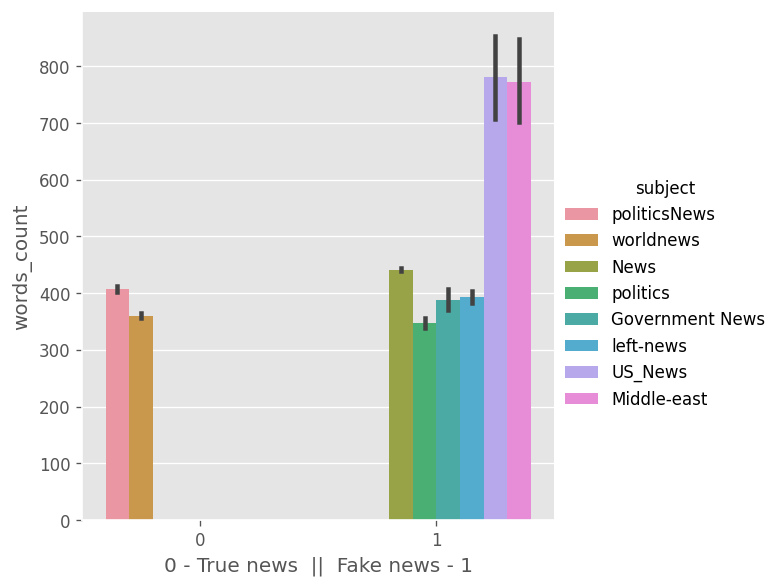

In [35]:
plt.rcParams['figure.figsize'] = [12,8]

sns.catplot(x='target', y='words_count', kind='bar', data=data, hue='subject')
plt.xlabel('0 - True news  ||  Fake news - 1')

# Data Cleaning

In [36]:
data['text'][1]

'WASHINGTON (Reuters) - Transgender people will be allowed for the first time to enlist in the U.S. military starting on Monday as ordered by federal courts, the Pentagon said on Friday, after President Donald Trump’s administration decided not to appeal rulings that blocked his transgender ban. Two federal appeals courts, one in Washington and one in Virginia, last week rejected the administration’s request to put on hold orders by lower court judges requiring the military to begin accepting transgender recruits on Jan. 1. A Justice Department official said the administration will not challenge those rulings. “The Department of Defense has announced that it will be releasing an independent study of these issues in the coming weeks. So rather than litigate this interim appeal before that occurs, the administration has decided to wait for DOD’s study and will continue to defend the president’s lawful authority in District Court in the meantime,” the official said, speaking on condition 

In [37]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import *

p_stemming = PorterStemmer()

In [38]:
def nltk_process(data):
    # Tokenization
    tokenList = word_tokenize(data)
    
    # Stemming
    stemedList = []
    for word in tokenList:
        stemedList.append(p_stemming.stem(word))

    # Lemmatization
    wordnet_lemmatizer = WordNetLemmatizer()
    lemmaList = []
    for word in stemedList:
        lemmaList.append(wordnet_lemmatizer.lemmatize(word))
        
    # Stopwords
    filtered_words = []
    nltk_stop_words = set(stopwords.words("english"))
    for word in lemmaList:
        if word not in nltk_stop_words:
            filtered_words.append(word)
    
    # Remove punct.
    
    for word in filtered_words:
        if word in string.punctuation:
            filtered_words.remove(word)
    
    return filtered_words

In [39]:
data['text'][1]

'WASHINGTON (Reuters) - Transgender people will be allowed for the first time to enlist in the U.S. military starting on Monday as ordered by federal courts, the Pentagon said on Friday, after President Donald Trump’s administration decided not to appeal rulings that blocked his transgender ban. Two federal appeals courts, one in Washington and one in Virginia, last week rejected the administration’s request to put on hold orders by lower court judges requiring the military to begin accepting transgender recruits on Jan. 1. A Justice Department official said the administration will not challenge those rulings. “The Department of Defense has announced that it will be releasing an independent study of these issues in the coming weeks. So rather than litigate this interim appeal before that occurs, the administration has decided to wait for DOD’s study and will continue to defend the president’s lawful authority in District Court in the meantime,” the official said, speaking on condition 

In [50]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
data['text'] = data['text'].apply(lambda x: nltk_process(x))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [51]:
data['text'][1]

['washington',
 'reuter',
 'transgend',
 'peopl',
 'allow',
 'first',
 'time',
 'enlist',
 'u.s.',
 'militari',
 'start',
 'monday',
 'order',
 'feder',
 'court',
 'pentagon',
 'said',
 'friday',
 'presid',
 'donald',
 'trump',
 '’',
 'administr',
 'decid',
 'appeal',
 'rule',
 'block',
 'hi',
 'transgend',
 'ban',
 'two',
 'feder',
 'appeal',
 'court',
 'one',
 'washington',
 'one',
 'virginia',
 'last',
 'week',
 'reject',
 'administr',
 '’',
 'request',
 'put',
 'hold',
 'order',
 'lower',
 'court',
 'judg',
 'requir',
 'militari',
 'begin',
 'accept',
 'transgend',
 'recruit',
 'jan.',
 '1',
 'A',
 'justic',
 'depart',
 'offici',
 'said',
 'administr',
 'challeng',
 'rule',
 '“',
 'depart',
 'defens',
 'ha',
 'announc',
 'releas',
 'independ',
 'studi',
 'issu',
 'come',
 'week',
 'So',
 'rather',
 'litig',
 'thi',
 'interim',
 'appeal',
 'befor',
 'occur',
 'administr',
 'ha',
 'decid',
 'wait',
 'dod',
 '’',
 'studi',
 'continu',
 'defend',
 'presid',
 '’',
 'law',
 'author',
 'd

In [52]:
type(data['text'][1])

list

In [53]:
data['text'] = [" ".join(text) for text in data['text'].values]

In [54]:
data['text'][1]

'washington reuter transgend peopl allow first time enlist u.s. militari start monday order feder court pentagon said friday presid donald trump ’ administr decid appeal rule block hi transgend ban two feder appeal court one washington one virginia last week reject administr ’ request put hold order lower court judg requir militari begin accept transgend recruit jan. 1 A justic depart offici said administr challeng rule “ depart defens ha announc releas independ studi issu come week So rather litig thi interim appeal befor occur administr ha decid wait dod ’ studi continu defend presid ’ law author district court meantim ” offici said speak condit anonym In septemb pentagon said creat panel senior offici studi implement direct trump prohibit transgend individu serv defens depart ha feb. 21 submit plan trump lawyer repres currently-serv transgend servic member aspir recruit said expect administr appeal rule conservative-major suprem court hope would happen pentagon spokeswoman heather b

# TF_IDF

In [55]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [56]:
tfidf = TfidfVectorizer(lowercase=False, stop_words='english')

In [58]:
text = data['text']
X = tfidf.fit_transform(text)
y = data['target']

In [59]:
data.head()

,title,text,subject,date,target,words_count,char_count,hashtags_count,email_counts,digits_count
0,"As U.S. budget fight looms, Republicans flip t...",washington reuter - head conserv republican fa...,politicsNews,"December 31, 2017",0,749,3907,0,0,"[2018, 7, 10, 11, 1, 5, 10, 20, 1, 5, 30, 2018..."
1,U.S. military to accept transgender recruits o...,washington reuter transgend peopl allow first ...,politicsNews,"December 29, 2017",0,624,3453,0,0,"[1, 21, 1, 8, 1, 1, 2017, 1, 2018]"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,washington reuter - special counsel investig l...,politicsNews,"December 31, 2017",0,457,2324,0,0,"[2016, 2018]"
3,FBI Russia probe helped by Australian diplomat...,washington reuter - trump campaign advis georg...,politicsNews,"December 30, 2017",0,376,2085,0,0,"[2016, 30, 2016]"
4,Trump wants Postal Service to charge 'much mor...,seattle/washington reuter - presid donald trum...,politicsNews,"December 29, 2017",0,852,4341,0,0,"[2, 2015, 11, 5, 46, 0, 86, 1, 175, 90, 62, 3,..."


In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 777)

In [61]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((35918, 105417), (8980, 105417), (35918,), (8980,))

# Support Vector Machine

In [62]:
from sklearn.svm import LinearSVC

In [63]:
clf_svc = LinearSVC()
clf_svc.fit(X_train, y_train)
y_pred = clf_svc.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4246
           1       1.00      1.00      1.00      4734

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



In [64]:
print(confusion_matrix(y_test, y_pred))

[[4228   18]
 [  20 4714]]


In [65]:
clf_svc.score(X_test, y_test)

0.9957683741648107

In [66]:
# Accuracy on the test set is near to 100%